In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist


In [2]:
# === STEP 1: Define ISODATA functions ===
def initialize_clusters(data, k):
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

def assign_clusters(data, centers):
    distances = cdist(data, centers)
    return np.argmin(distances, axis=1)

def update_centers(data, labels, k):
    new_centers = []
    for i in range(k):
        points = data[labels == i]
        if len(points) == 0:
            continue
        new_centers.append(np.mean(points, axis=0))
    return np.array(new_centers)

def isodata(data, k_init=8, max_iter=50, min_cluster_size=30, std_threshold=8, merge_distance=3):
    data = np.array(data, dtype=np.float32)
    centers = initialize_clusters(data, k_init)
    k = len(centers)

    for iteration in range(max_iter):
        labels = assign_clusters(data, centers)
        new_centers = update_centers(data, labels, k)

        # Merge nearby centers
        merged_centers = []
        skip = set()
        for i in range(len(new_centers)):
            if i in skip:
                continue
            merged = False
            for j in range(i + 1, len(new_centers)):
                if np.linalg.norm(new_centers[i] - new_centers[j]) < merge_distance:
                    merged_center = (new_centers[i] + new_centers[j]) / 2
                    merged_centers.append(merged_center)
                    skip.update([i, j])
                    merged = True
                    break
            if not merged:
                merged_centers.append(new_centers[i])
        centers = np.array(merged_centers)
        k = len(centers)

        # Split high-variance clusters
        divided_centers = []
        for i in range(k):
            cluster_data = data[labels == i]
            if len(cluster_data) < min_cluster_size:
                continue
            std_dev = np.std(cluster_data, axis=0)
            if np.any(std_dev > std_threshold):
                center1 = centers[i] + std_dev / 2
                center2 = centers[i] - std_dev / 2
                divided_centers.extend([center1, center2])
            else:
                divided_centers.append(centers[i])
        centers = np.array(divided_centers)
        k = len(centers)

    final_labels = assign_clusters(data, centers)
    return final_labels, centers


In [3]:
# === STEP 2: Define paths ===
image_folder = "/content/drive/MyDrive/Colab Notebooks/isodata_img/image_color"  # Folder with images
output_folder = "/content/drive/MyDrive/Colab Notebooks/isodata_img/segmentation_output/isodata_scores_img_color"
os.makedirs(output_folder, exist_ok=True)


In [4]:
# === STEP 3: Process images ===
results = []

for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None:
            print(f"Failed to load {filename}")
            continue

        h, w, c = image.shape
        pixels = image.reshape((-1, 3))  # Flatten to (num_pixels, 3) for RGB

        try:
            labels, centers = isodata(pixels, k_init=4)
            score = silhouette_score(pixels, labels)
            print(f"{filename} - Silhouette Score: {score:.4f}")
            results.append({"image": filename, "silhouette_score": score})
        except Exception as e:
            print(f"{filename} - Error: {e}")
            results.append({"image": filename, "silhouette_score": None})
            continue

        # Reconstruct segmented image by assigning cluster centers
        segmented = centers[labels].reshape((h, w, 3)).astype(np.uint8)
        output_path = os.path.join(output_folder, f"segmented_{filename}")
        segmented_bgr = cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, segmented_bgr)

        # === Display original and segmented ===
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title(f"Original - {filename}")
        axs[0].axis('off')

        axs[1].imshow(segmented)
        axs[1].set_title("ISODATA Segmentation (Color)")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [5]:
# === STEP 4: Save CSV and plot scores ===
df = pd.DataFrame(results)
csv_path = os.path.join(output_folder, "isodata_scores_img_color.csv")
df.to_csv(csv_path, index=False)

# Remove missing scores
df = df.dropna()
df


,image,silhouette_score
0,N_101_VF__2.jpg,0.286483
1,G_108_RO__8.jpg,0.376790
2,G_108_HF__10.jpg,0.349268
3,G_124_SP__3.jpg,0.260816


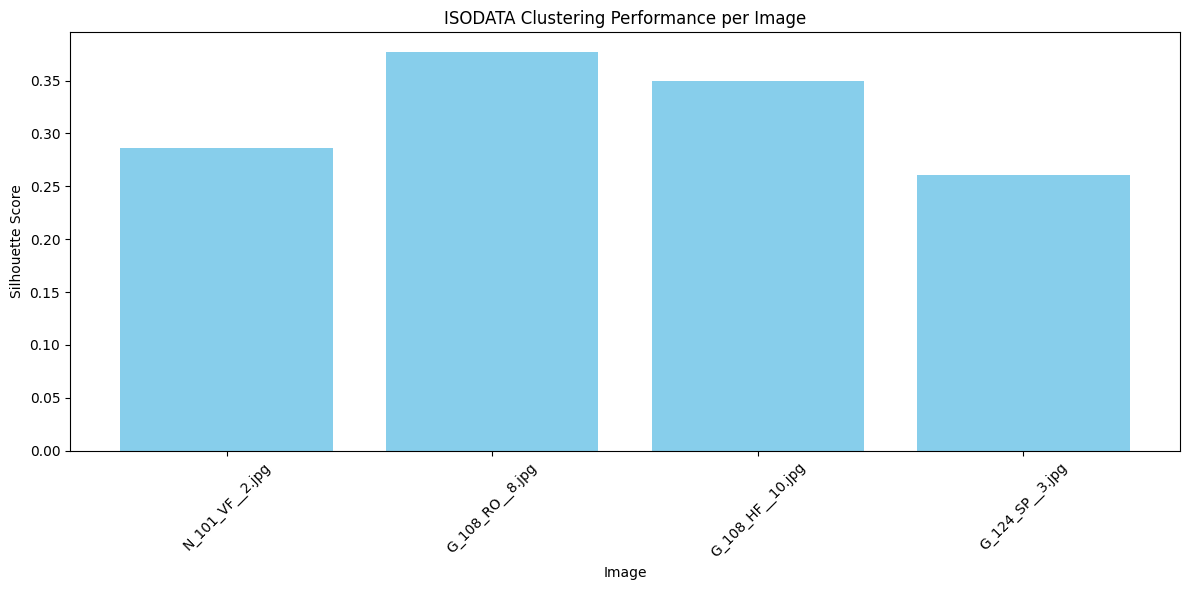

In [6]:
# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.bar(df["image"], df["silhouette_score"], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Image")
plt.ylabel("Silhouette Score")
plt.title("ISODATA Clustering Performance per Image")
plt.tight_layout()
plt.show()
